In [1]:
import datetime
import sys
sys.path.append("..")
import random
from numpy.random import default_rng
import torch.autograd as autograd
from typing import List
from torch.autograd import Variable
import torch.backends.cudnn as cudnn
from sklearn.metrics import (adjusted_rand_score, calinski_harabasz_score,
                             normalized_mutual_info_score, silhouette_score)
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import preprocessing


import utils
from sklearn import metrics
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.manifold import TSNE

import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional
import torch.nn.functional as F
from random import sample
from torch.nn.parameter import Parameter
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import scanpy as sc
import time
import os

import scipy

from torch.cuda.amp import GradScaler, autocast

torch.cuda.set_device(1)

def setup_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True

plt.ion()
plt.show()
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
path= "../"
# check available files
# !ls ../real_data

# torch.autograd.set_detect_anomaly(True)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
dataset = "simul1_dropout_47_b1_1000_b2_2000"
cellinfo_df = pd.read_csv('%s/cellinfo.txt' % (dataset), sep="\t")
counts_df = pd.read_csv('%s/counts.txt' % (dataset), sep="\t")
de_genes_df = pd.read_csv('%s/de_genes.txt' % (dataset), sep="\t")
geneinfo_df = pd.read_csv('%s/geneinfo.txt' % (dataset), sep="\t")
true_down_genes_df = pd.read_csv('%s/true_down_genes.txt' % (dataset), sep="\t")
true_up_genes_df = pd.read_csv('%s/true_up_genes.txt' % (dataset), sep="\t")

from anndata import AnnData

adata = AnnData(X=counts_df.transpose(), obs=cellinfo_df.iloc[:, 1:],
                    dtype='float32')

# obs_label_colname ="celltype"
adata

le = preprocessing.LabelEncoder()
new_batch = le.fit_transform(adata.obs["Batch"])
adata.obs["Batch"] = new_batch

new_batch = [str(each) for each in new_batch]
adata.obs["Batch_num"] = new_batch

# change also for the groups we want to preserve
le_2 = preprocessing.LabelEncoder()
new_groups = le_2.fit_transform(adata.obs["Group"])
new_groups = [int(each) for each in new_groups]
# new_groups = [str(each) for each in new_groups]
adata.obs["Group"] = new_groups

adata.obs["Group_num"] = le_2.inverse_transform(adata.obs['Group'])
adata.obs["Group_num"] = [str(each) for each in adata.obs["Group_num"]]

In [3]:
adata.layers["counts"] = adata.X

In [4]:
# flavor: seurat_v3, cell_ranger & log = false
def sub_data_preprocess(adata: sc.AnnData, n_top_genes: int = 5000, batch_key: str = None, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3) -> sc.AnnData:
    sc.pp.filter_cells(adata, min_genes=min_genes)
    sc.pp.filter_genes(adata, min_cells=min_cells)
#     if flavor == 'seurat_v3':
# # #         count data is expected when flavor=='seurat_v3'
# #         sc.pp.highly_variable_genes(
# #             adata, flavor=flavor, batch_key = batch_key)
    sc.pp.highly_variable_genes(
        adata, flavor=flavor, batch_key = batch_key, n_top_genes=n_top_genes)

#     if flavor != 'seurat_v3':.
#         # log-format data is expected when flavor!='seurat_v3'
#         sc.pp.highly_variable_genes(
#             adata, n_top_genes=n_top_genes, flavor=flavor)
    sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
    sc.pp.log1p(adata)
    return adata


def data_preprocess(adata: sc.AnnData, key: str = 'batch', n_top_genes: int = 1795, flavor: str = 'seurat_v3', min_genes: int = 200, min_cells: int = 3, n_batch: int = 2) -> sc.AnnData:
    print('Establishing Adata for Next Step...')
    hv_adata = sub_data_preprocess(adata, n_top_genes=n_top_genes, batch_key = key, flavor=flavor, min_genes=min_genes, min_cells=min_cells)
#     if len(adata.var.index) > n_top_genes:
#         hv_adata = hv_adata[:, hv_adata.var['highly_variable']]
#     hv_adata.X = np.expm1(hv_adata.X)
    print('PreProcess Done.')
    return hv_adata

In [5]:
batch_str = "Batch"

adata = data_preprocess(adata, batch_str)
adata  # Output the basic information of the preprocessed data.

Establishing Adata for Next Step...
PreProcess Done.


AnnData object with n_obs × n_vars = 7891 × 4695
    obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'log1p'
    layers: 'counts'

In [6]:
adata.layers["log_norm"] = adata.X

In [7]:
label_str = "Batch"

# split per batch into new objects.
batches = list(set(adata.obs[label_str]))
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs[label_str] == batch,]

length_data = []

for batch in batches:
    length = len(alldata[batch])
    
    length_data.append(length)
    
# getting the batch with the most number of cell to be the anchoring/reference batch
anchor_index = np.argmax(length_data)

print(batches[anchor_index])

3


In [8]:
# # apply the pre processing onto the anndata
# # first create layer for the anndata

adata.layers["X_raw"] = adata.layers["log_norm"]

In [9]:
# define non_anchor batch
# adata.layers["X_raw"] = adata.X.copy()

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import scanpy as sc
import scanorama

In [11]:
# var_genes_all = adata.var.highly_variable

# print("Highly variable genes: %d"%sum(var_genes_all))

In [12]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5, batch_key = 'Batch_num')

print("Highly variable genes intersection: %d"%sum(adata.var.highly_variable_intersection))

print("Number of batches where gene is variable:")
print(adata.var.highly_variable_nbatches.value_counts())

var_genes_batch = adata.var.highly_variable_nbatches > 0

Highly variable genes intersection: 248
Number of batches where gene is variable:
0    1987
1     971
2     864
3     625
4     248
Name: highly_variable_nbatches, dtype: int64


In [13]:
var_select = adata.var.highly_variable_nbatches > 2
var_genes = var_select.index[var_select]
len(var_genes)

873

In [14]:
# split per batch into new objects.
batches = adata.obs['Batch_num'].cat.categories.tolist()
alldata = {}
for batch in batches:
    alldata[batch] = adata[adata.obs['Batch_num'] == batch,]

alldata

{'0': View of AnnData object with n_obs × n_vars = 993 × 4695
     obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     layers: 'counts', 'log_norm', 'X_raw',
 '1': View of AnnData object with n_obs × n_vars = 1982 × 4695
     obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts'
     var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'dispersions', 'dispersions_norm', 'highly_variable_intersection'
     uns: 'hvg', 'log1p'
     layers: 'counts', 'log_norm', 'X_raw',
 '2': View of AnnData object with n_obs × n_vars = 1968 × 4695
     obs: 'Batch', 'Group', 'ExpLibSize', 'Batch_num', 'Group_num', 'n_genes', 'n_counts'
     var

In [15]:
sc.pp.combat(adata, key = "Batch_num")

/home/rom/miniconda3/envs/CLEAR/lib/python3.8/site-packages/scanpy/preprocessing/_combat.py:340: RuntimeWarning: divide by zero encountered in true_divide
  (abs(g_new - g_old) / g_old).max(), (abs(d_new - d_old) / d_old).max()


In [16]:
output_results = adata.X

In [17]:
import scanpy as sc
import pandas as pd
import seaborn as sns

# verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.verbosity = 1
sc.settings.set_figure_params(
    dpi=200, frameon=False, figsize=(3, 3), facecolor='white')


# observer batch effect
# sc.pp.scale(adata)
# sc.pp.pca(adata)
# sc.pp.neighbors(adata)
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=['batch', "celltype"],
#            palette=sc.pl.palettes.vega_20_scanpy)


In [18]:
# sc.tl.umap(adata)

# sc.pl.umap(adata, color=["celltype"],
#            palette=sc.pl.palettes.vega_20_scanpy)

In [19]:
output_results.shape

(7891, 4695)

In [20]:
from sklearn.decomposition import PCA

adata.obsm["X_latent"] = output_results.copy()

# output_results_norm = sc.pp.normalize_per_cell(output_results, counts_per_cell_after = 1e4, copy = True)
# output_results_log_norm = sc.pp.log1p(output_results_norm)
# output_results_scaled = sc.pp.scale(output_results_log_norm)
# output_results_scaled = sc.pp.scale(output_results, copy = True)

# adata.obsm["X_latent_norm"] = output_results_log_norm
# adata.obsm["X_latent_scaled"] = output_results_scaled.copy()

pca = PCA(n_components = 50, random_state = 8)

# pca.fit(sc.pp.scale(adata.obsm["X_latent"], copy = True))

# X_pca = pca.transform(sc.pp.scale(adata.obsm["X_latent"], copy = True))

pca.fit(adata.obsm["X_latent"])

X_pca = pca.transform(adata.obsm["X_latent"])

adata.obsm["X_pca"] = X_pca

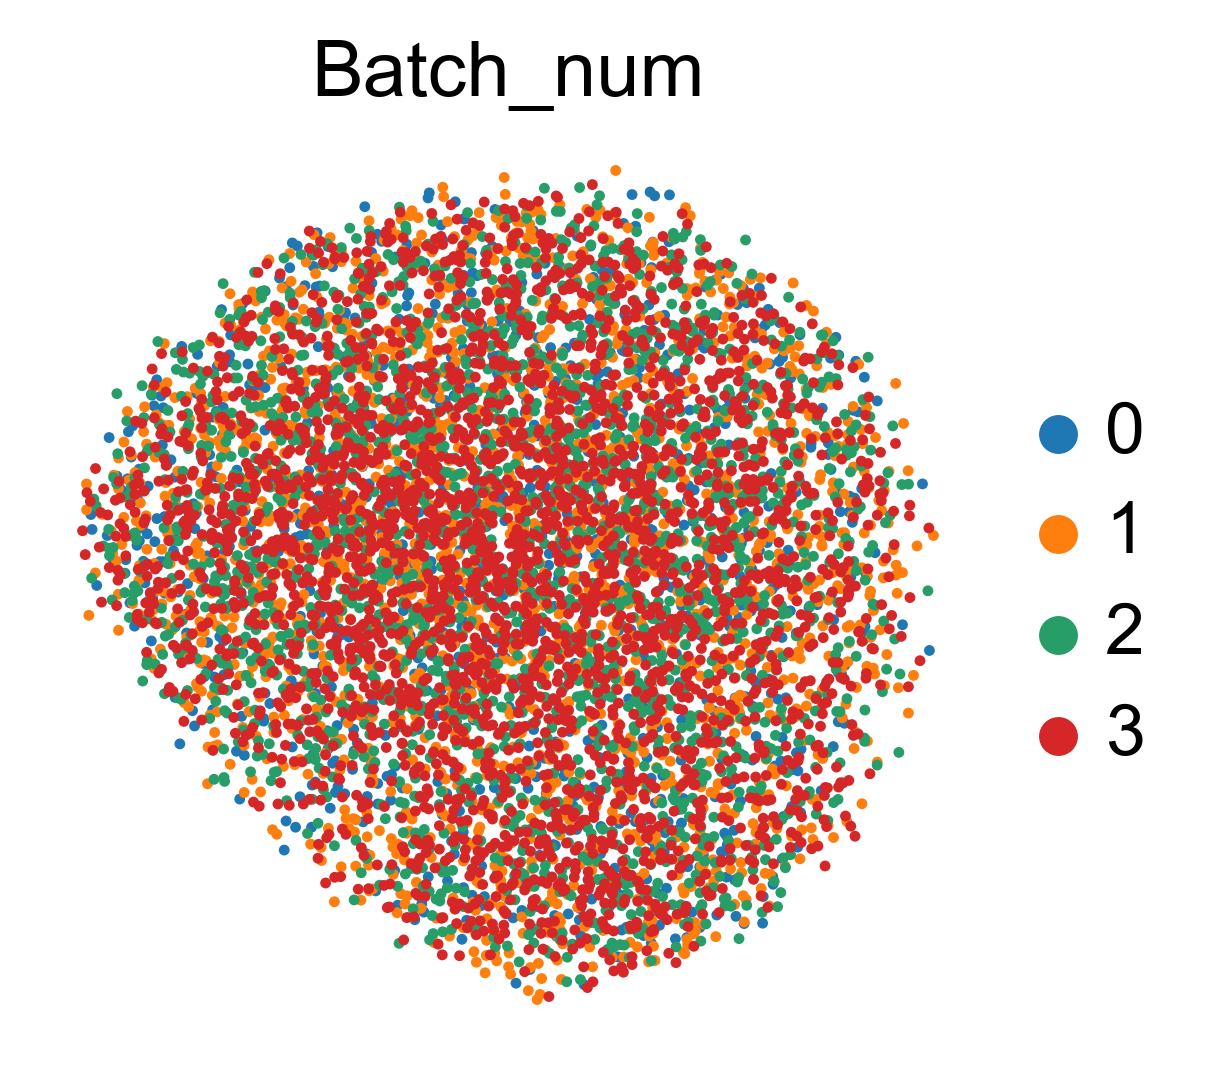

In [21]:
sc.pp.neighbors(adata, use_rep='X_pca', n_neighbors=30)
# sc.external.pp.bbknn(adata_all, batch_key='batch', use_rep='X_latent')
sc.tl.umap(adata)
sc.pl.umap(adata, color=['Batch_num'],
           palette=sc.pl.palettes.vega_20_scanpy)


In [22]:
# # adata.obsm["X_latent"] = output_results

# # sc.pp.neighbors(adata, use_rep='X_latent', n_neighbors=30)
# # sc.external.pp.bbknn(adata, batch_key='batch', use_rep='X_latent')
# # sc.tl.umap(adata)
# sc.pl.umap(adata, color=["batch", "CellType"],
#            palette=sc.pl.palettes.vega_20_scanpy)

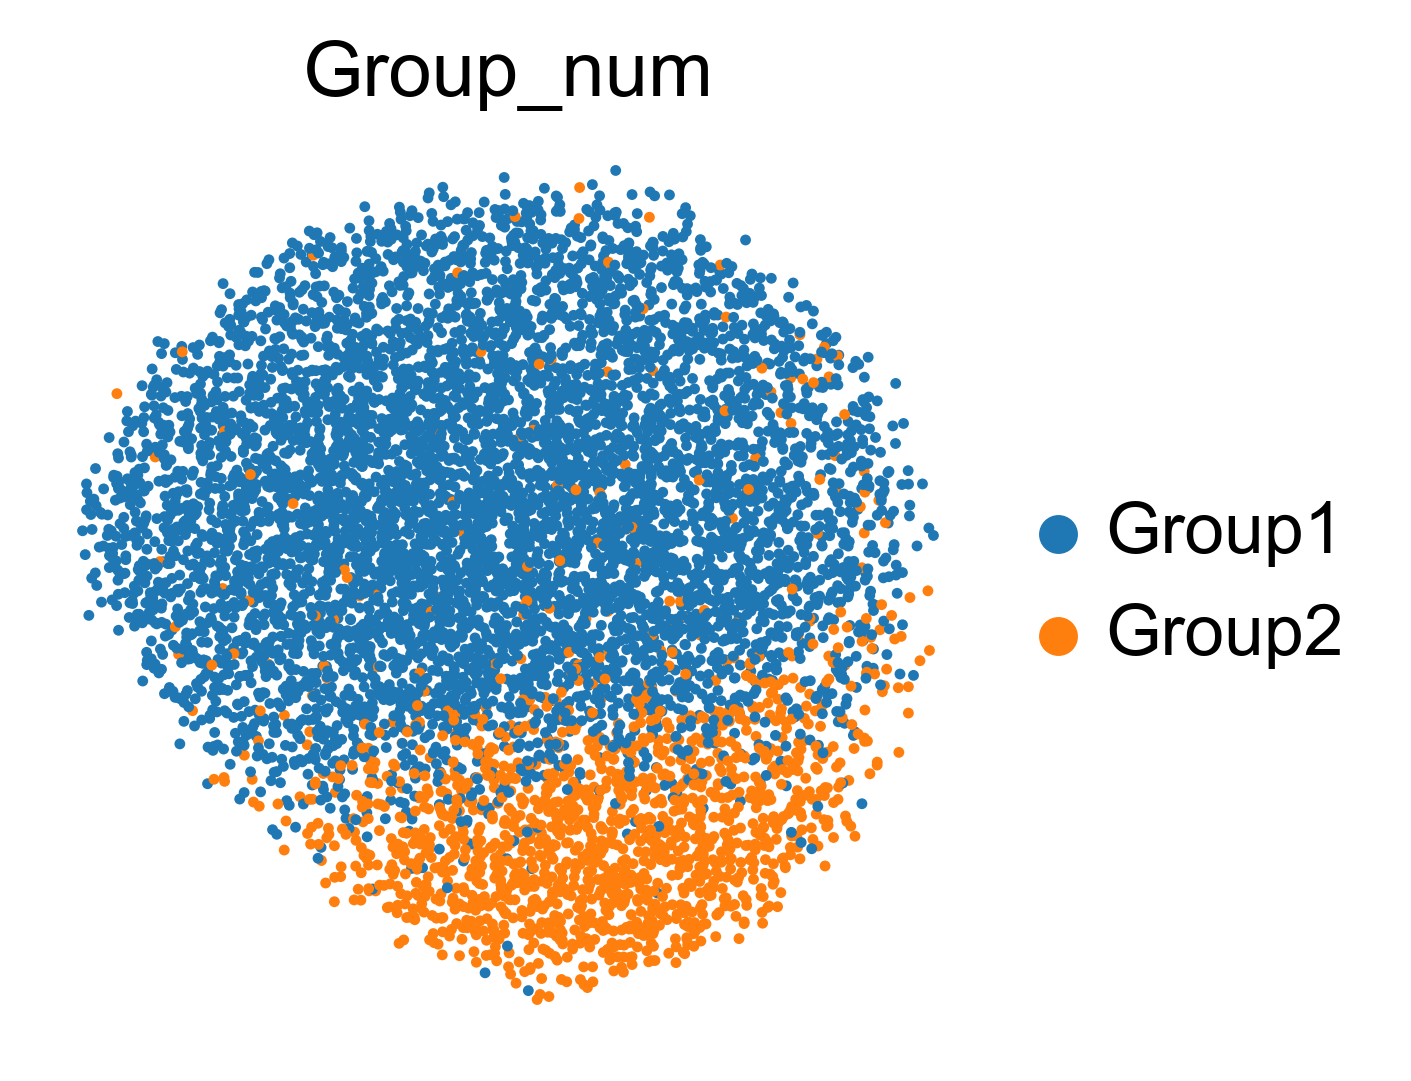

In [23]:
sc.pl.umap(adata, color=["Group_num"],
           palette=sc.pl.palettes.vega_20_scanpy)

In [24]:
# test_df = pd.DataFrame(output_results)
# sum(test_df.iloc[0,:])

In [25]:
# adata.obsm["X_latent"] = output_results

In [26]:
adata.write_h5ad("combat_simulation_1.h5ad")

In [27]:
import scipy.special
from sklearn.metrics.cluster import adjusted_rand_score


def ari(adata, group1, group2, implementation="sklearn"):
    """Adjusted Rand Index
    The function is symmetric, so group1 and group2 can be switched
    For single cell integration evaluation the comparison is between predicted cluster
    assignments and the ground truth (e.g. cell type)
    :param adata: anndata object
    :param group1: string of column in adata.obs containing labels
    :param group2: string of column in adata.obs containing labels
    :param implementation: if set to 'sklearn', uses sklearn's implementation,
        otherwise native implementation is taken
    """

    group1 = adata.obs[group1].to_numpy()
    group2 = adata.obs[group2].to_numpy()

    if len(group1) != len(group2):
        raise ValueError(
            f"different lengths in group1 ({len(group1)}) and group2 ({len(group2)})"
        )

    return adjusted_rand_score(group1, group2)

resolutions = None

if resolutions is None:
    n = 20
    resolutions = [2 * x / n for x in range(1, n + 1)]

score_max = 0
res_max = resolutions[0]
clustering = None
score_all = []
use_rep = "X_pca"
cluster_key = "louvain"
label_key = "Group"

try:
    adata.uns["neighbors"]
except KeyError:
    if verbose:
        print("computing neighbours for opt_cluster")
    sc.pp.neighbors(adata, use_rep=use_rep)
    
for res in resolutions:
    sc.tl.louvain(adata, resolution=res, key_added=cluster_key)
    score = ari(adata, label_key, cluster_key)
    score_all.append(score)
    if score_max < score:
        score_max = score
        res_max = res
        clustering = adata.obs[cluster_key]
        
score_max

0.7576752013707384